In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from time import sleep
import sys
import MeCab
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

# スクレイピング

In [4]:
def scraping_kashi(url):
    sleep(5)
    html = requests.get(url)
    soup = BeautifulSoup(html.text, "html.parser")
    return soup

#surpec
soup = scraping_kashi("https://www.uta-net.com/artist/8918/")
contents = []
#URL
contents.append(soup.find_all(href=re.compile('/song/\d+/$')))
#曲名
contents.append(soup.find_all(href=re.compile('/song/\d+/$')))
#artist名
contents.append(soup.find_all(class_=re.compile("td2")))
#作詞者
contents.append(susoup.find_all(class_=re.compile("td3")))
#作曲者名
contents.append(soup.find_all(class_=re.compile("td4")))
info = []
base_url = "https://www.uta-net.com/"
for i, content in enumerate(contents):
    part = []
    for element in content:
        if i == 0:
            part.append(base_url+element.get("href"))
        else:
            part.append(element.text)
    info.append(part)


In [6]:
data = pd.DataFrame({
    "URL":info[0],
    "song":info[1],
    "artist":info[2],
    "Lyricist":info[3],
    "Composer":info[4]
})

In [7]:
url_data = [scraping_kashi(url) for url in data.URL]

In [8]:
import re
lyric = [re.sub(r"<.+?>"," ",str(url.find(id="kashi_area"))) for url in url_data]
data["Lyric"] = lyric

In [11]:
data.head()

URL              song     artist  \
0  https://www.uta-net.com//song/142067/                青空  supercell   
1  https://www.uta-net.com//song/155917/  Yeah Oh Ahhh Oh!  supercell   
2  https://www.uta-net.com//song/155914/  We're Still Here  supercell   
3   https://www.uta-net.com//song/99271/            うたかた花火  supercell   
4  https://www.uta-net.com//song/147877/             M.K.O  supercell   

  Lyricist Composer                                              Lyric  
0      ryo      ryo   空の青さが気に食わなくて ずっと下を向いて歩いた 列をなして歩くローファーさん ちょっぴり...  
1      ryo      ryo   One, Two, One, Two, One, Two, Yeah Yeah!! oh ...  
2      ryo      ryo   そのチケットは人にあげたりすることはできなくて 望んでもないのに一人　旅に出るよ 様々な人...  
3      ryo      ryo   あふれる人でにぎわう8月末のお祭り 浴衣を着て下駄も履いて からん　ころん　音をたてる ふ...  
4      ryo      ryo   いつもあなたあいも変わらずバカなくせしてバカにして あたしそういうのわかるのよ　あいづちだ...

### 年代と商品番号追加

In [309]:
year = []
album = []
for url in data.URL:
    soup = scraping_kashi(url)
    year.append(soup.find("div", {"id":"view_amazon"}).text[5:15])
    album.append(soup.find("div", {"id":"view_amazon"}).text[20:32])
data["year"] = year
data["album"] = album

### 商品番号とアルバム名を紐づける

In [310]:
product_name = {
    'SRCL-11279SM':"#Love feat. Ann, gaku",
    'SRCL-7081SMR':"君の知らない物語",
    'SRCL-7203SMR':"さよならメモリーズ",
    'SRCL-7333SMR':"うたかた花火/星が瞬くこんな夜に",
    'SRCL-7488SMR':"Today Is A Beautiful Day",
    'SRCL-7795SMR':"My Dearest",
    'SRCL-7885SMR':"僕らのあしあと / 告白",
    'SRCL-7886SMR':"僕らのあしあと / 告白",
    'SRCL-8194SMR':"銀色飛行船",
    'SRCL-8245SMR':"The Bravery",
    'SRCL-8284SMR':"拍手喝采歌合",
    'SRCL-8416SMR':"ZIGAEXPERIENTIA"}
data['album'] = data.album.apply(lambda x : product_name[x])

### CSVとして保存

In [50]:
data.to_csv("supercell.csv")

In [51]:
data = pd.read_csv("supercell.csv")

# 形態素解析

In [138]:
import unicodedata
import neologdn
import MeCab
import itertools
def tokenize(text_list):
    keitaiso = []
    for text in text_list:
        text = unicodedata.normalize("NFKC", text)
        text = neologdn.normalize(text)
        text = text.lower()
        node = tagger.parseToNode(text)
        line = []
        while node:
            features = node.feature.split(",")
            if features[0] != "BOS/EOS":
                if features[0] not in ["助詞","助動詞"]:
                    token = features[6] \
                            if features[6] != "*" \
                            else node.surface
                    line.append(token)
            node = node.next
        keitaiso.append(line)
    result = list(itertools.chain.from_iterable(keitaiso))
    return result
# tokenize(test)

In [233]:
#アルバムごとのに歌詞をまとめる
lyrics = np.array( [] )
for name in data.album.unique():
    album = data[data.album == name].copy()
    lyrics = np.append(lyrics, " ".join(tokenize(album.Lyric.tolist())))

#ベクトル化
vectorizer = TfidfVectorizer(token_pattern=u'(?u)\\b\\w+\\b') #1文字のトークンも対象とする
#ベクトル化 11*1810 1810は単語の数
tfidf = vectorizer.fit_transform(lyrics)

In [208]:
tfidf

<11x1810 sparse matrix of type '<class 'numpy.float64'>'
	with 3265 stored elements in Compressed Sparse Row format>

In [241]:
word_vec = {} #単語のID
for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1]):
    word_vec[v] = k
    
#各アルバムの各単語のスコアリングをDataFrameにする
vec_array = tfidf.toarray()
albums = [] #11個のアルバムを格納
for vec in vec_array: #11回
    words_album = []
    vector_album = []
    #0でない部分のタプル行
    for i in vec.nonzero()[0]: #3265
        words_album.append(word_vec[i])
        vector_album.append(vec[i])
    albums.append(pd.DataFrame({
        "words":words_album,
        "vector":vector_album
    }))

In [244]:
tfidf.nonzero()

(array([ 0,  0,  0, ..., 10, 10, 10], dtype=int32),
 array([ 593, 1594, 1474, ..., 1342,  352, 1486], dtype=int32))

In [245]:
albums[0]

words    vector
0      あいつ  0.038597
1      あたし  0.217980
2    あっけない  0.051345
3      あなた  0.028305
4       あの  0.055175
..     ...       ...
251     頼る  0.051345
252      顔  0.062280
253    願える  0.102691
254   飛び出す  0.051345
255     食う  0.087776

[256 rows x 2 columns]

word_cloud 描画

In [287]:
def draw_wordcloud(df, col_name_noun, col_name_quant, fig_title, masking=True):
    word_freq_dict = {}
    stop_words = set(['いる','する','れる','てる','なる','られる','よう','の','いく','ん','せる','いい','ない','ある','しまう','・','さ'])
    for i, v in df.iterrows():
        if v[col_name_noun] not in stop_words:
            word_freq_dict[v[col_name_noun]] = v[col_name_quant]
    
    from wordcloud import WordCloud
    #text = " ".join(words)
    if masking:
        tele_mask = np.array(Image.open(r"C:\hogehoge\generate_song\supercell.jpg"))
    else:
        tele_mask = None
    wordcloud = WordCloud(background_color="white",
                          font_path= r"C:\hogehoge\generate_song\ipaexg.ttf",
                          mask=tele_mask,
                          min_font_size=15,
                          max_font_size=200,
                          width=1000,
                          height=1000
                          )
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(fig_title, fontsize=25)

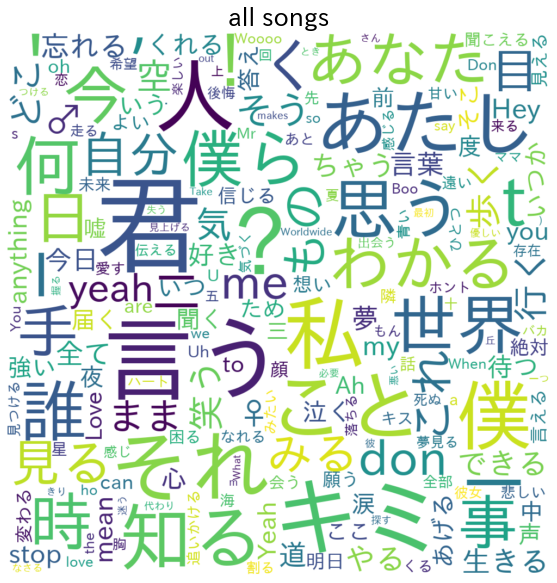

In [289]:
word_list = get_word_list(data.Lyric.tolist())                    
word_freq = pd.Series(word_list).value_counts() #pandasのSeriesに変換してvalue_counts()
words_df = pd.DataFrame({'noun' : word_freq.index,
             'noun_count' : word_freq.tolist()})
draw_wordcloud(words_df,'noun','noun_count','all songs',False)

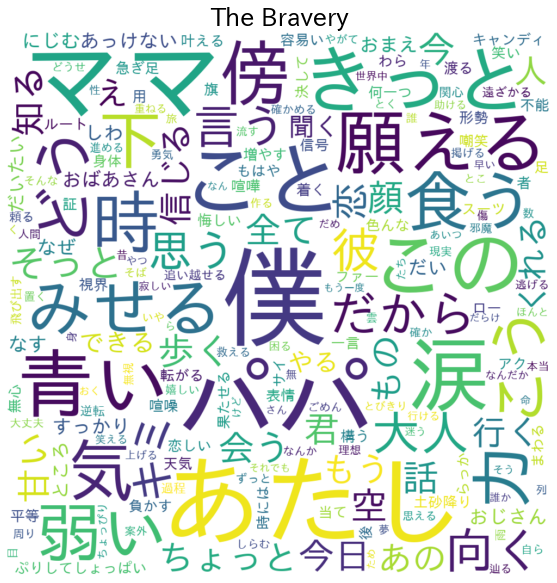

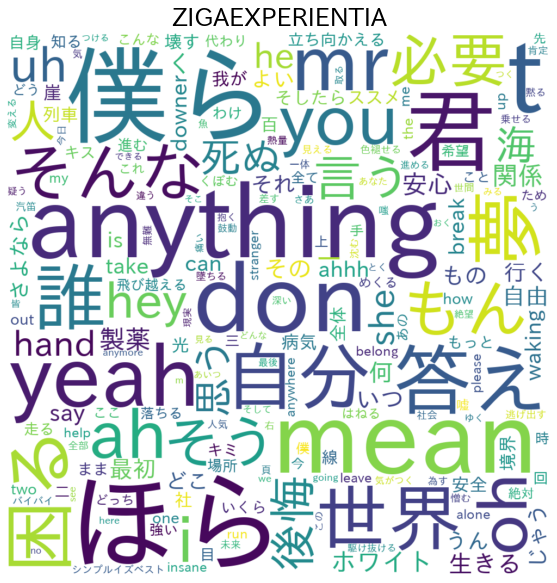

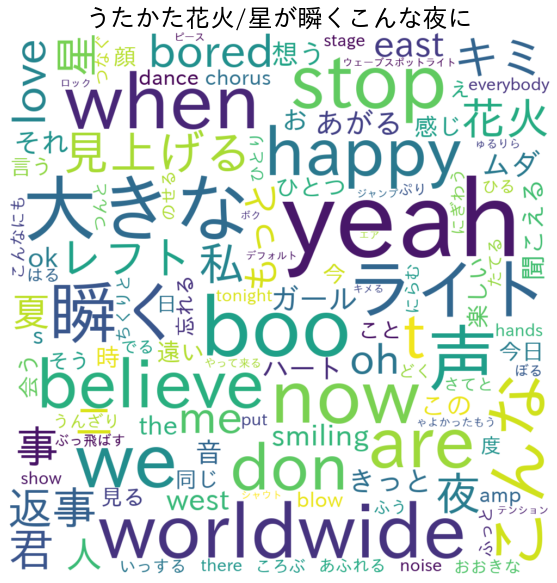

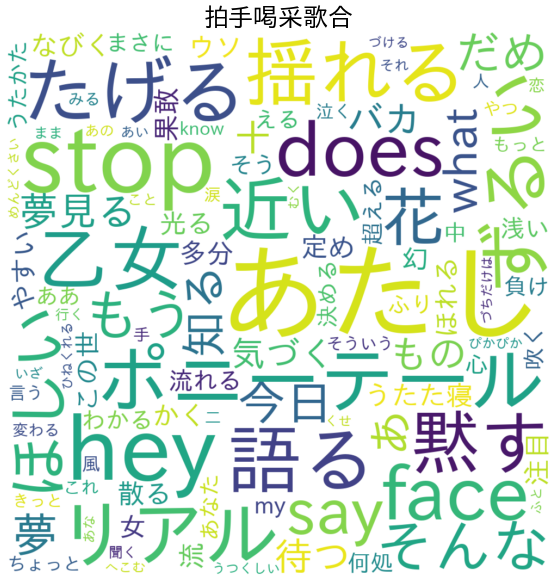

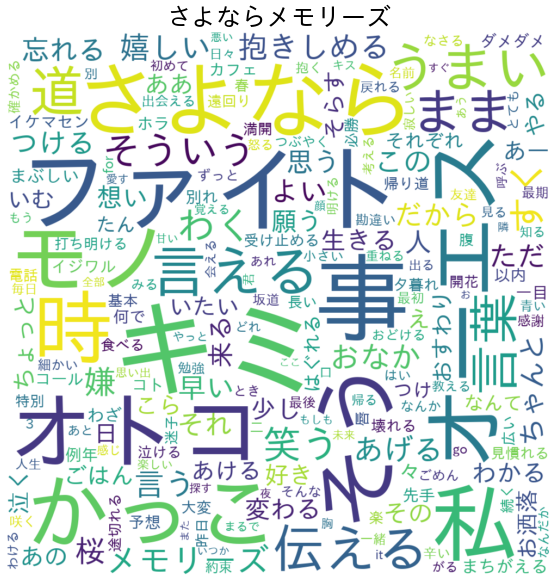

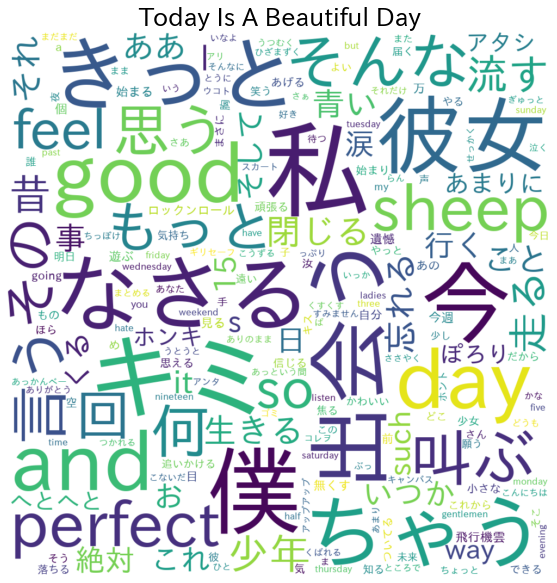

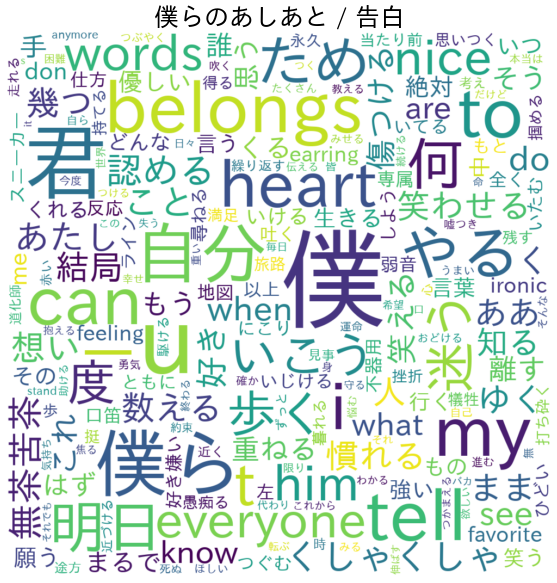

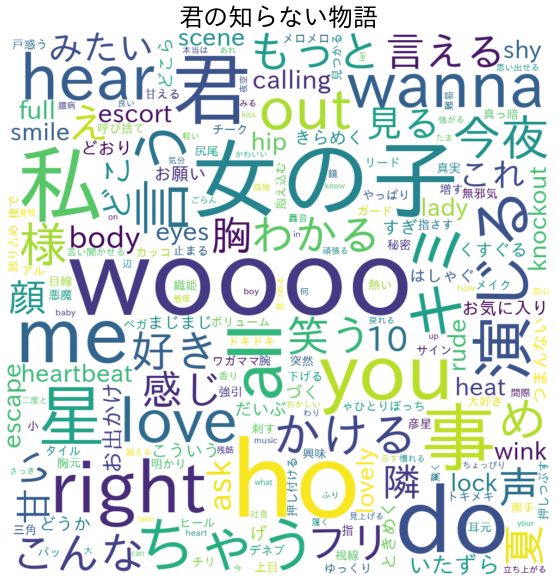

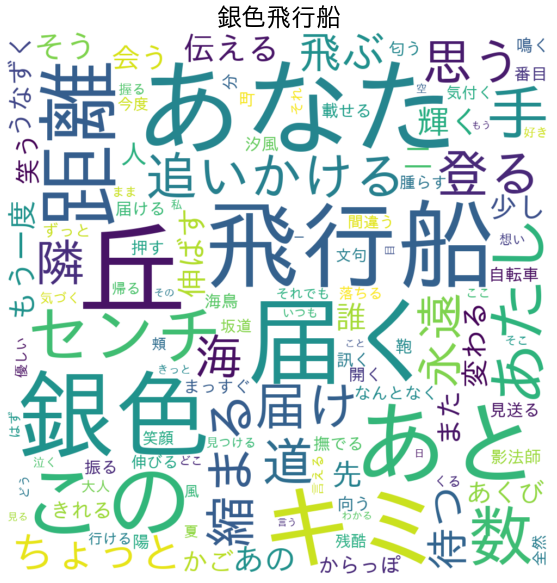

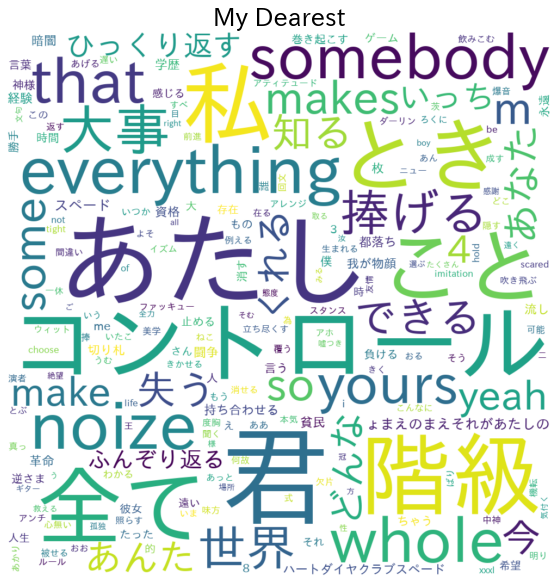

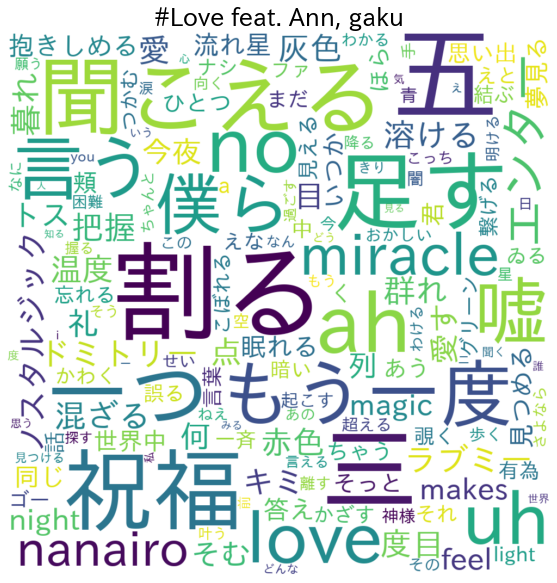

In [306]:
for i,album in enumerate(albums):
    fig_title = data.album.unique().tolist()[i]
    draw_wordcloud(album,'words','vector',fig_title,False)

vectorizer.vocabulary_  
単語:INDEX

In [170]:
vectorizer.vocabulary_ 

{'青い': 1564,
 '食う': 1583,
 'ずっと': 357,
 '向く': 884,
 '歩く': 1197,
 'なす': 455,
 'ロー': 716,
 'ファー': 682,
 'さん': 343,
 'ちょっぴり': 403,
 '邪魔': 1530,
 '思う': 1055,
 'てる': 424,
 'どう': 440,
 'いい': 226,
 '追い越せる': 1501,
 '信号': 798,
 '無視': 1263,
 'する': 356,
 '渡る': 1243,
 'おばあさん': 273,
 'きっと': 294,
 '見える': 1415,
 'いる': 251,
 '関心': 1548,
 'こんな': 328,
 '寂しい': 977,
 'なる': 459,
 '会う': 780,
 '急ぎ足': 1059,
 'スーツ': 639,
 'おじさん': 269,
 '案外': 1178,
 'ない': 452,
 '本当': 1164,
 'とこ': 431,
 '自分': 1386,
 'こと': 319,
 '色んな': 1396,
 '転がる': 1482,
 'あっけない': 209,
 '今日': 770,
 'ほんと': 506,
 '天気': 948,
 '喧噪': 906,
 'やがて': 549,
 '遠ざかる': 1526,
 '悪い': 1066,
 '無心': 1260,
 'すっかり': 353,
 '忘れる': 1046,
 'だいたい': 392,
 'そんな': 378,
 'もの': 541,
 '泣く': 1222,
 'あたし': 207,
 'ママ': 697,
 'そっと': 368,
 'とく': 430,
 'くれる': 310,
 '甘い': 1284,
 'キャンディ': 614,
 '置く': 1367,
 'しらむ': 346,
 'ぷりしてしょっぱい': 500,
 'らっか': 569,
 '知る': 1318,
 'こう': 312,
 'やる': 556,
 'ちょっと': 402,
 '大人': 941,
 'なれる': 460,
 '悲しい': 1069,
 'いつか': 243,
 '全部': 821,
 'それ': 373,
 '思える': 1

In [184]:
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import inv, eigs
l = [[0, 1, 2],
     [3, 0, 4],
     [0, 0, 0]]

csr = csr_matrix(l)
print(csr)

  (0, 1)	1
  (0, 2)	2
  (1, 0)	3
  (1, 2)	4


In [186]:
r, c = csr.nonzero()
#csrのタプルの行と列のarray
print(r, c)

array([0, 0, 1, 1], dtype=int32)